<a href="https://colab.research.google.com/github/PacktPublishing/Machine-Learning-for-Time-Series-with-Python/blob/master/chapter9/Fuzzy_time_series_forecasting.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install -U git+https://github.com/PYFTS/pyFTS

  Cloning https://github.com/PYFTS/pyFTS to /tmp/pip-req-build-fckshmo6
  Running command git clone -q https://github.com/PYFTS/pyFTS /tmp/pip-req-build-fckshmo6
  Created wheel for pyFTS: filename=pyFTS-1.6-cp37-none-any.whl size=217117 sha256=ddfecaf2c0994f8aed39d5fc8a1ae8bd2d6a553cd359b40457ec4a49ad33d624
  Stored in directory: /tmp/pip-ephem-wheel-cache-w244f4f7/wheels/e7/32/a9/230470113df5a73242a5a6d05671cb646db97abf14bbce2644
Successfully built pyFTS


In [ ]:
pip install SimpSOM

  Created wheel for SimpSOM: filename=SimpSOM-1.3.4-cp37-none-any.whl size=17088 sha256=17c279ca22c13f6bc784b1c23d696a812fa8961b38cb0156c6b4a5fcf3549c50
  Stored in directory: /root/.cache/pip/wheels/51/76/ee/c02f0bc20af4cd8f46ee4142ebf7bb654b737d6d8f2360d26b
Successfully built SimpSOM


### External libraries import

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "17"

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from pyFTS.common import Transformations

tdiff = Transformations.Differential(1)

In [ ]:
from pyFTS.data import NASDAQ, SP500

datasets = {
    "SP500": SP500.get_data()[11500:16000],
    "NASDAQ": NASDAQ.get_data()
}

train_split = 2000

In [ ]:
datasets["NASDAQ"]

array([2373.61, 2434.87, 2597.32, ..., 5215.29, 5226.75, 5210.88])

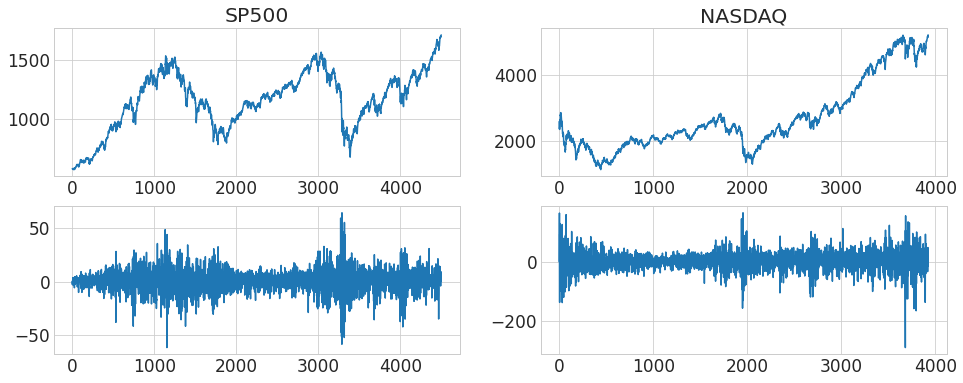

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=[16, 6])

for count, (dataset_name, dataset) in enumerate(datasets.items()):
    dataset_diff = tdiff.apply(dataset)

    ax[0][count].plot(dataset)
    ax[1][count].plot(dataset_diff)
    ax[0][count].set_title(dataset_name)

### Statistics

In [ ]:
from statsmodels.tsa.stattools import adfuller

rows = []

for count, (dataset_name, dataset) in enumerate(datasets.items()):
    row = [dataset_name]
    result = adfuller(dataset)
    row.extend([result[0],result[1]])
    row.extend([value for key, value in result[4].items()])
    rows.append(row)
    
pd.DataFrame(rows, columns=['Dataset','ADF Statistic','p-value','Cr. Val. 1%','Cr. Val. 5%','Cr. Val. 10%'])

,Dataset,ADF Statistic,p-value,Cr. Val. 1%,Cr. Val. 5%,Cr. Val. 10%
0,SP500,-1.747171,0.406987,-3.431811,-2.862186,-2.567114
1,NASDAQ,0.476224,0.984132,-3.432022,-2.862279,-2.567163


In [ ]:
from pyFTS.models import song
from pyFTS.partitioners import Grid

models = {}

for count, (dataset_name, dataset) in enumerate(datasets.items()):
    partitioner_diff = Grid.GridPartitioner(data=dataset, npart=15, transformation=tdiff)
    model = song.ConventionalFTS(partitioner=partitioner_diff)
    model.name = dataset_name
    model.append_transformation(tdiff)
    model.fit(dataset[:train_split], order=1)
    models[dataset_name] = model

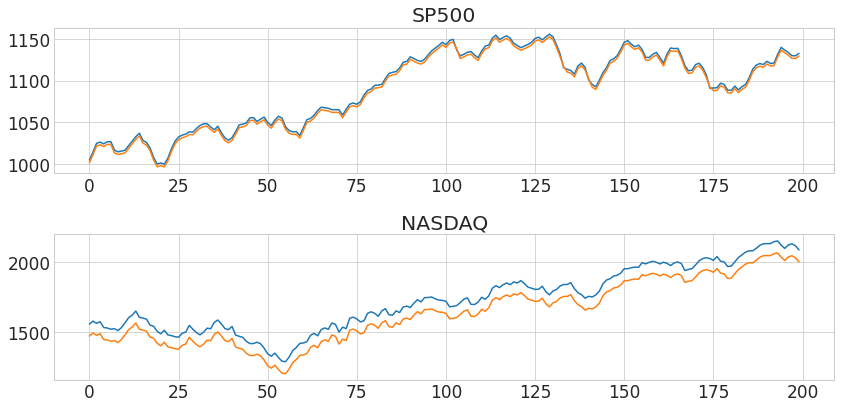

In [ ]:
_, ax = plt.subplots(nrows=2, ncols=1, figsize=[12, 6])

for count, (dataset_name, dataset) in enumerate(datasets.items()):
    ax[count].plot(dataset[train_split:train_split+200])
    model = models[dataset_name]
    forecasts = model.predict(dataset[train_split:train_split+200], steps_ahead=1)
    ax[count].plot(forecasts)
    ax[count].set_title(dataset_name)
    
plt.tight_layout()

In [ ]:
from pyFTS.benchmarks import Measures

rows = []

for count, (dataset_name, dataset) in enumerate(datasets.items()):
    row = [dataset_name]
    test = dataset[train_split:train_split+200]
    model = models[dataset_name]
    row.extend(Measures.get_point_statistics(test, model))
    rows.append(row)
    
pd.DataFrame(rows,columns=["Dataset", "RMSE", "MAPE", "Theil's U"]).set_index("Dataset")

,RMSE,MAPE,Theil's U
Dataset,,,
SP500,6.76,0.52,1.22
NASDAQ,90.85,5.14,3.79


## Residual Analysis

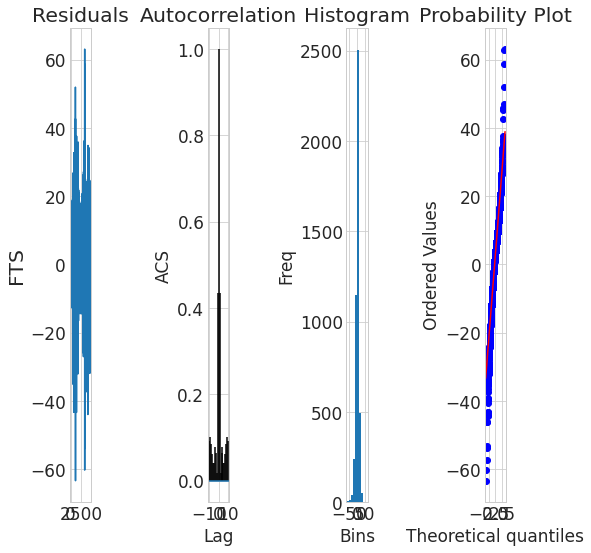

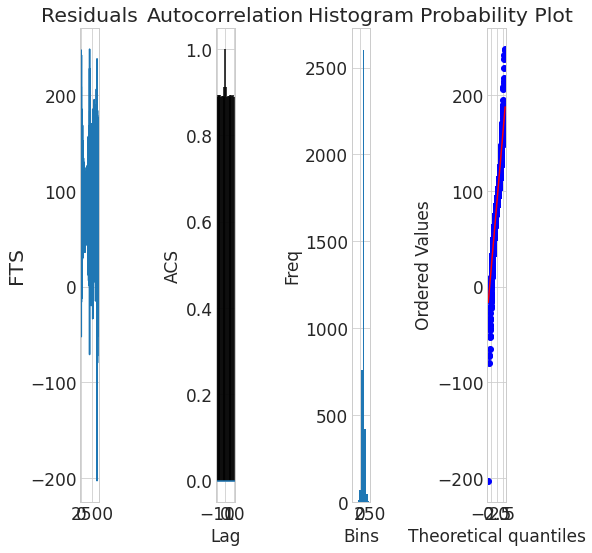

In [ ]:
from pyFTS.benchmarks import ResidualAnalysis as ra

for count, (dataset_name, dataset) in enumerate(datasets.items()):
    model = models[dataset_name]
    ra.plot_residuals_by_model(dataset, [model])